# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

In [3]:
# %matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


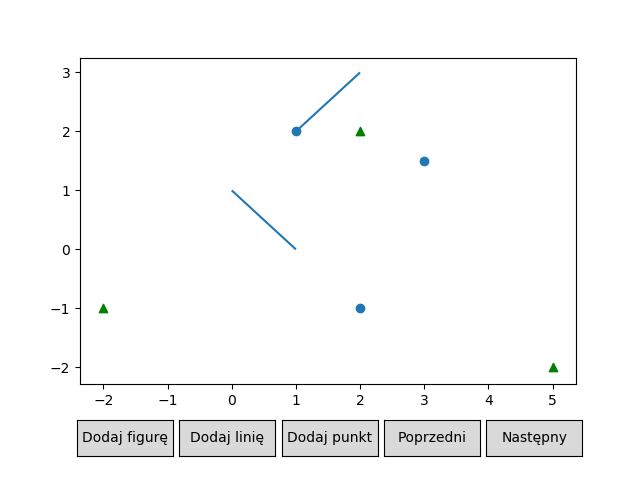

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [5]:
# scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
#               [LinesCollection([[(1,2)], [(0,1),(1,0)]])]), 
#         Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
#                PointsCollection([(5, -2)], color='black')])]
# plot = Plot(scenes)

# with open('somefile.json', 'w') as file:
#     file.write(plot.toJson())
    
# #somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
# with open('somefile.json', 'r') as file:
#     json = file.read()
    
# plot2 = Plot(json=json)
# plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


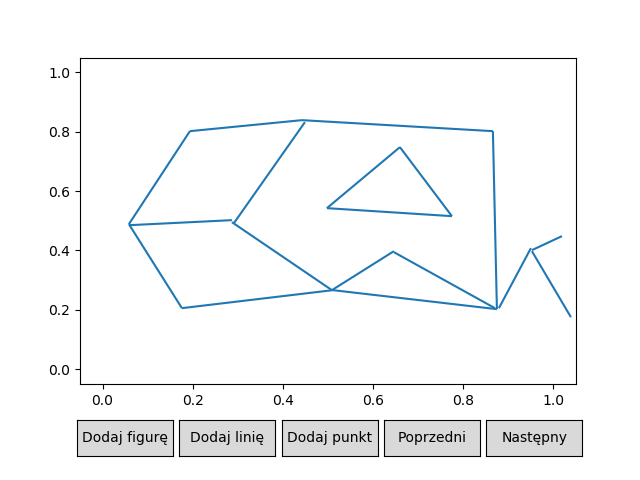

In [9]:
#Dodaj tu punkty, figury i/lub odcinki!
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [12]:
aa = plot1.get_added_figure()
for a in aa:
    print(a.lines)

[[(0.17600176411290325, 0.20560087316176462), (0.058461441532258074, 0.48868910845588237)], [(0.058461441532258074, 0.48868910845588237), (0.19374369959677418, 0.8021082261029411)], [(0.19374369959677418, 0.8021082261029411), (0.44213079637096775, 0.8391793045343137)], [(0.44213079637096775, 0.8391793045343137), (0.8657195060483872, 0.8021082261029411)], [(0.8657195060483872, 0.8021082261029411), (0.8745904737903226, 0.202230775122549)], [(0.8745904737903226, 0.202230775122549), (0.5108807963709677, 0.266262637867647)], [(0.5108807963709677, 0.266262637867647), (0.17600176411290325, 0.20560087316176462)]]
[]
[[(0.29132434475806457, 0.492059206495098), (0.4487840221774194, 0.8324391084558824)]]
[[(0.4975743447580645, 0.5426106770833332), (0.7747920866935484, 0.5156498927696078)], [(0.7747920866935484, 0.5156498927696078), (0.659469506048387, 0.7481866574754901)], [(0.659469506048387, 0.7481866574754901), (0.4975743447580645, 0.5426106770833332)]]
[]


In [13]:
bb = plot1.get_added_lines()
print(bb)

[<__main__.LinesCollection object at 0x7fb8723fef10>, <__main__.LinesCollection object at 0x7fb872640cd0>, <__main__.LinesCollection object at 0x7fb872647310>, <__main__.LinesCollection object at 0x7fb872953550>, <__main__.LinesCollection object at 0x7fb8724341d0>, <__main__.LinesCollection object at 0x7fb873251fd0>, <__main__.LinesCollection object at 0x7fb87248b910>, <__main__.LinesCollection object at 0x7fb872655250>, <__main__.LinesCollection object at 0x7fb8726405d0>, <__main__.LinesCollection object at 0x7fb872968950>, <__main__.LinesCollection object at 0x7fb8729c02d0>]


In [14]:
for b in bb:
    print(b.lines)

[[(0.060679183467741926, 0.48531901041666664), (0.28688886088709675, 0.5021695006127451)]]
[]
[[(0.5086630544354839, 0.266262637867647), (0.6461630544354838, 0.3976964613970588)]]
[[(0.6461630544354838, 0.39432636335784316), (0.8701549899193549, 0.20560087316176462)]]
[[(0.28688886088709675, 0.4954293045343137), (0.5086630544354839, 0.266262637867647)]]
[[(0.8790259576612903, 0.20560087316176462), (0.9499936995967743, 0.40780675551470585)]]
[[(0.9522114415322581, 0.4010665594362745), (1.018743699596774, 0.44824793198529406)]]
[]
[]
[]
[[(1.038703377016129, 0.1752699908088235), (0.9522114415322581, 0.3976964613970588)]]


In [3]:
lines = [[(0.17600176411290325, 0.20560087316176462), (0.058461441532258074, 0.48868910845588237)], [(0.058461441532258074, 0.48868910845588237), (0.19374369959677418, 0.8021082261029411)], [(0.19374369959677418, 0.8021082261029411), (0.44213079637096775, 0.8391793045343137)], [(0.44213079637096775, 0.8391793045343137), (0.8657195060483872, 0.8021082261029411)], [(0.8657195060483872, 0.8021082261029411), (0.8745904737903226, 0.202230775122549)], [(0.8745904737903226, 0.202230775122549), (0.5108807963709677, 0.266262637867647)], [(0.5108807963709677, 0.266262637867647), (0.17600176411290325, 0.20560087316176462)], [(0.4975743447580645, 0.5426106770833332), (0.7747920866935484, 0.5156498927696078)], [(0.7747920866935484, 0.5156498927696078), (0.659469506048387, 0.7481866574754901)], [(0.659469506048387, 0.7481866574754901), (0.4975743447580645, 0.5426106770833332)], [(0.29132434475806457, 0.492059206495098), (0.058461441532258074, 0.48868910845588237)], [(0.29132434475806457, 0.492059206495098), (0.5108807963709677, 0.266262637867647)], [(0.29132434475806457, 0.492059206495098), (0.44213079637096775, 0.8391793045343137)], [(0.5108807963709677, 0.266262637867647), (0.6461630544354838, 0.39432636335784316)], [(0.6461630544354838, 0.39432636335784316), (0.8745904737903226, 0.202230775122549)], [(0.8745904737903226, 0.202230775122549), (0.9522114415322581, 0.4010665594362745)], [(0.9522114415322581, 0.4010665594362745), (1.018743699596774, 0.44824793198529406)], [(0.9522114415322581, 0.4010665594362745), (1.038703377016129, 0.1752699908088235), (0.9522114415322581, 0.3976964613970588)]]

In [3]:
lines = [[(5.0, 40.0), (55.0, 20.0)], [(30.0, 60.0), (70.0, 60.0)], [(60.0, 55.0), (95.0, 15.0)], [(40.0, 5.0), (95.0, 15.0)]]

<IPython.core.display.Javascript object>


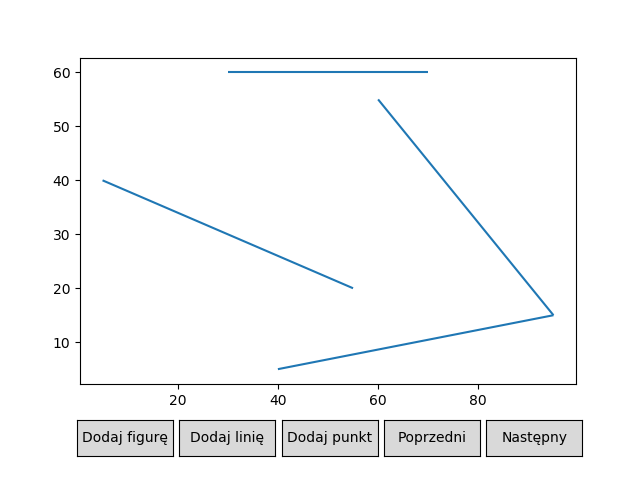

In [4]:
%matplotlib notebook
plot2=Plot(lines=[LinesCollection(lines)])
plot2.draw() 

### Rozwiązanie

In [5]:
import random as random
import math as math
import numpy as np



In [6]:
class Point:
    def __init__(self,x,y,flag):
        self.x=x
        self.y=y
        self.flag=flag

    def __eq__(self,p2):
        if isinstance(p2, Point):
            return self.x==p2.x and self.y==p2.y
        return False

    def __lt__(self,p2):
        return self.x<p2.x
    
    def __gt__(self,p2):
        return self.x>p2.x

    def __hash__(self):
        return hash(self.x)

In [96]:
class LineSegment:
    def __init__(self,leftEndPoint,rightEndPoint):
        self.start=leftEndPoint
        self.end=rightEndPoint
        self.m=(leftEndPoint.y-rightEndPoint.y)/(leftEndPoint.x-rightEndPoint.x)
        self.b=leftEndPoint.y-self.m*leftEndPoint.x
    
    def __eq__(self,ls2):
        if isinstance(ls2, LineSegment):
            return self.start==ls2.start and self.end==ls2.end
        return False
    
    def get_line(self):
        return [(self.start.x, self.start.y), (self.end.x, self.end.y)]

    def get_y(self, x):
        return self.m * x + self.b

In [64]:
class Wall:
    def __init__(self,x,yStart,yMin,yMax):
        self.x=x
        self.ys=yStart
        self.yi=yMin
        self.ya=yMax
        
    def get_line(self):
        return [(self.x, self.yi), (self.x, self.ya)]
    
    def get_points(self):
        return [(self.x, self.ys), (self.x, self.yi), (self.x, self.ya)]
    
    def __eq__(self,w2):
        return self.x==w2.x
    
    def __lt__(self,w2):
        return self.x<w2.x
    
    def __gt__(self,w2):
        return self.x>w2.x

In [160]:
class Trapezoid:
    def __init__(self,left,right,above,below):
        self.left=left
        self.right=right
        self.above=above
        self.below=below
    
    def __eq__(self,t2):
        if isinstance(t2, Trapezoid):
            return self.left==t2.left and self.right==t2.right and self.above==t2.above and self.below==t2.below
        return False
    
    def get_lines_collection(self):
        return [self.left.get_line(), self.right.get_line(), self.above.get_line(), self.below.get_line()]
    
    def get_walls_lines(self):
        return [self.left.get_line(), self.right.get_line()]
    
    def get_walls_points(self):
        return [(self.left.x, self.left.yi), (self.left.x, self.left.ya), (self.right.x, self.right.yi), (self.right.x, self.right.ya)]

In [161]:
class DAG:
    def __init__(self,leftChild,current,rightChild):
        self.leftChild=leftChild
        self.itself=current
        self.rightChild=rightChild

    def find(self, item):
        if isinstance(self.itself, type(item)):
            if self.itself == item:
                return self
        if self.leftChild:
            lc = self.leftChild.find(item)
            if lc:
                return lc
        if self.rightChild:
            rc = self.rightChild.find(item)
            if rc:
                return rc
        return None

In [162]:
#strona 42 na slajdach z upla

def pointLocate(p,node, scenes=[]):
    if isinstance(node.itself,Trapezoid):
        leftWall = node.itself.left
        rightWall = node.itself.right
        above = node.itself.above
        below = node.itself.below
        scenes.append(Scene(points=[PointsCollection([(p.x, p.y)], color='red')], lines=[LinesCollection([[(leftWall.x, leftWall.yi), (leftWall.x, leftWall.ya)],
                                                    [(rightWall.x, rightWall.yi), (rightWall.x, rightWall.ya)],
                                                    [(above.start.x, above.start.y), (above.end.x, above.end.y)],
                                                    [(below.start.x, below.start.y), (below.end.x, below.end.y)]])]))
        return node
    elif isinstance(node.itself,Point):
        if p<node.itself:
            return pointLocate(p,node.leftChild, scenes)
        else:
            return pointLocate(p,node.rightChild, scenes)
    elif isinstance(node.itself,LineSegment):
        if p.y<node.itself.get_y(p.x):
            return pointLocate(p,node.rightChild, scenes)
        else:
            return pointLocate(p,node.leftChild, scenes)

In [163]:
def wallCreate(pTrapezoid, qTrapezoid, p, q):
    pyMin = pTrapezoid.below.m*p.x+pTrapezoid.below.b
    qyMin = qTrapezoid.below.m*q.x+qTrapezoid.below.b
    pyMax = pTrapezoid.above.m*p.x+pTrapezoid.above.b
    qyMax = qTrapezoid.above.m*q.x+qTrapezoid.above.b
    return Wall(p.x, p.y, pyMin, pyMax), Wall(q.x, q.y, qyMin, qyMax)


In [174]:
import copy
from functools import reduce

def trapezoidal_map(lines):
    xMin = lines[0][0][0]
    xMax = lines[0][0][0]
    yMin = lines[0][0][1]
    yMax = lines[0][0][1]
    lineSegments = []
    for line in lines:
        if line[0][0] <= line[1][0]:
            start = Point(line[0][0], line[0][1], 'P')
            end = Point(line[1][0], line[1][1], 'Q')
        else:
            start = Point(line[1][0], line[1][1], 'P')
            end = Point(line[0][0], line[0][1], 'Q')
        if start.x < xMin:
            xMin = start.x
        if end.x > xMax:
            xMax = end.x
        if start.y < yMin:
            yMin = start.y
        if end.y > yMax:
            yMax = end.y
        lineSegments.append(LineSegment(start, end))
    xMin, xMax = xMin - 0.2 * (xMax - xMin), xMax + 0.2 * (xMax - xMin)
    yMin, yMax = yMin - 0.2 * (yMax - yMin), yMax + 0.2 * (yMax - yMin)
    random.shuffle(lineSegments)
    boundingBox = Trapezoid(Wall(xMin, yMax, yMin, yMax), Wall(xMax, yMin, yMin, yMax), LineSegment(Point(xMin, yMax, 'P'), Point(xMax, yMax, 'Q')), LineSegment(Point(xMin, yMin, 'P'), Point(xMax, yMin, 'Q')))
    trapezoids = [boundingBox]
    dag = DAG(None, boundingBox, None)
    trapScenes = []
    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])
        
    basic_scene = Scene(points=[PointsCollection(points, color='gainsboro')], lines=[LinesCollection(lines, color='gainsboro')])
    trapScenes.append(basic_scene)
    scene = copy.deepcopy(basic_scene)
    scene.lines.append(LinesCollection([[(xMin, yMin), (xMin, yMax)], [(xMin, yMin), (xMax, yMin)], [(xMax, yMin), (xMax, yMax)], [(xMin, yMax), (xMax, yMax)]], color='green'))
    basic_scene = scene
    trapScenes.append(scene)
    for ls in lineSegments:
        p = ls.start
        q = ls.end
        pNode = pointLocate(p, dag)
        qNode = pointLocate(q, dag)
        pTrapezoid = pNode.itself
        qTrapezoid = qNode.itself
        
        scene = copy.deepcopy(basic_scene)
        scene.lines.append(LinesCollection(reduce(list.__add__, [trap.get_walls_lines() for trap in trapezoids]), color='green'))
#         scene.points.append(PointsCollection(reduce(list.__add__, [trap.get_walls_points() for trap in trapezoids]), color='green'))
        scene.lines.append(LinesCollection([ls.get_line()], color='red'))
        scene.points.append(PointsCollection([(ls.start.x, ls.start.y), (ls.end.x, ls.end.y)], color='red'))
        trapScenes.append(scene)

        for trapezoid in trapezoids:
            if trapezoid.below.start == p and q.y > trapezoid.below.get_y(q.x):
                pTrapezoid = trapezoid
                pNode = dag.find(pTrapezoid)
            elif trapezoid.above.start == p and q.y < trapezoid.above.get_y(q.x):
                pTrapezoid = trapezoid
                pNode = dag.find(pTrapezoid)
            elif trapezoid.below.end == q and p.y > trapezoid.below.get_y(q.x):
                qTrapezoid = trapezoid
                qNode = dag.find(qTrapezoid)
            elif trapezoid.above.end == q and p.y < trapezoid.above.get_y(q.x):
                qTrapezoid = trapezoid
                qNode = dag.find(qTrapezoid)

        pWall, qWall = wallCreate(pTrapezoid, qTrapezoid, p, q)

        if pTrapezoid == qTrapezoid:
            trapezoids.remove(pTrapezoid)
            aTrapezoid = Trapezoid(
                pTrapezoid.left, pWall, pTrapezoid.above, pTrapezoid.below)
            bTrapezoid = Trapezoid(pWall, qWall, pTrapezoid.above, ls)
            cTrapezoid = Trapezoid(pWall, qWall, ls, pTrapezoid.below)
            dTrapezoid = Trapezoid(
                qWall, pTrapezoid.right, pTrapezoid.above, pTrapezoid.below)
            trapezoids.append(aTrapezoid)
            trapezoids.append(bTrapezoid)
            trapezoids.append(cTrapezoid)
            trapezoids.append(dTrapezoid)

            sNewNode = DAG(DAG(None, bTrapezoid, None),
                           ls, DAG(None, cTrapezoid, None))
            pNode.itself = p
            pNode.leftChild = DAG(None, aTrapezoid, None)
            pNode.rightChild = DAG(sNewNode, q, DAG(None, dTrapezoid, None))

        else:
            intersectedTrapezoids = [pTrapezoid]

            nextTrapezoid = pTrapezoid
            while nextTrapezoid != qTrapezoid:
                nextCandidates = [c for c in trapezoids if (isinstance(c.left, Wall) and c.left.x == nextTrapezoid.right.x) or
                                  (isinstance(c.left, float) and c.left == nextTrapezoid.right.x)]
                for c in nextCandidates:
                    if c.above.get_y(nextTrapezoid.right.x) > ls.get_y(nextTrapezoid.right.x) > c.below.get_y(nextTrapezoid.right.x):
                        nextTrapezoid = c
                        intersectedTrapezoids.append(c)
                        break

            prevTop = None
            prevBottom = None

            for c in intersectedTrapezoids:
                if c == pTrapezoid or c.right == pTrapezoid.left:
                    leftTrapezoid = Trapezoid(pTrapezoid.left, pWall,
                                              pTrapezoid.above, pTrapezoid.below)
                    topTrapezoid = Trapezoid(
                        pWall, pTrapezoid.right, pTrapezoid.above, ls)
                    bottomTrapezoid = Trapezoid(
                        pWall, pTrapezoid.right, ls, pTrapezoid.below)

                    trapezoids.remove(pTrapezoid)
                    trapezoids.append(topTrapezoid)
                    trapezoids.append(bottomTrapezoid)

                    if ls.start == pTrapezoid.above.start or ls.start == pTrapezoid.below.start:

                        pNode.itself = ls
                        pNode.leftChild = DAG(None, topTrapezoid, None)
                        pNode.rightChild = DAG(None, bottomTrapezoid, None)
                    else:
                        trapezoids.append(leftTrapezoid)

                        pNode.itself = p
                        pNode.leftChild = DAG(None, leftTrapezoid, None)
                        pNode.rightChild = DAG(
                            DAG(None, topTrapezoid, None), ls, DAG(None, bottomTrapezoid, None))

                    prevTop = pNode.rightChild.leftChild
                    prevBottom = pNode.rightChild.rightChild
                elif c == qTrapezoid or c.left == qTrapezoid.right:
                    leftWall = qTrapezoid.left
                    if ls.get_y(leftWall.x) < leftWall.ys:

                        qTrapezoid.left.yi = ls.get_y(qTrapezoid.left.x)

                        topTrapezoid = Trapezoid(
                            qTrapezoid.left, qWall, qTrapezoid.above, ls)
                        bottomTrapezoid = Trapezoid(
                            prevBottom.itself.left, qWall, ls, qTrapezoid.below)
                        rightTrapezoid = Trapezoid(qWall, qTrapezoid.right,
                                                   qTrapezoid.above, qTrapezoid.below)

                        trapezoids.remove(qTrapezoid)
                        trapezoids.append(topTrapezoid)
                        trapezoids.append(bottomTrapezoid)

                        if ls.end == qTrapezoid.below.end or ls.end == qTrapezoid.above.end:
                            qNode.itself = ls
                            qNode.leftChild = DAG(None, topTrapezoid, None)
                            qNode.rightChild = DAG(None, bottomTrapezoid, None)

                        else:
                            trapezoids.append(rightTrapezoid)

                            qNode.itself = q
                            qNode.rightChild = DAG(None, rightTrapezoid, None)
                            qNode.leftChild = DAG(
                                DAG(None, topTrapezoid, None), ls, DAG(None, bottomTrapezoid, None))

                        trapezoids.remove(prevBottom.itself)
                        prevBottom.itself = bottomTrapezoid
                    else:
                        qTrapezoid.left.ya = ls.get_y(qTrapezoid.left.x)

                        topTrapezoid = Trapezoid(prevTop.itself.left,
                                                 qWall, qTrapezoid.above, ls)
                        bottomTrapezoid = Trapezoid(
                            qTrapezoid.left, qWall, ls, qTrapezoid.below)
                        rightTrapezoid = Trapezoid(qWall, qTrapezoid.right,
                                                   qTrapezoid.above, qTrapezoid.below)

                        trapezoids.remove(qTrapezoid)
                        trapezoids.append(topTrapezoid)
                        trapezoids.append(bottomTrapezoid)

                        if ls.end == qTrapezoid.above.end or ls.end == qTrapezoid.below.end:
                            qNode.itself = ls
                            qNode.leftChild = DAG(None, topTrapezoid, None)
                            qNode.rightChild = DAG(None, bottomTrapezoid, None)
                        else:
                            trapezoids.append(rightTrapezoid)

                            qNode.itself = q
                            qNode.rightChild = DAG(None, rightTrapezoid, None)
                            qNode.leftChild = DAG(
                                DAG(None, topTrapezoid, None), ls, DAG(None, bottomTrapezoid, None))

                        trapezoids.remove(prevTop.itself)
                        prevTop.itself = topTrapezoid
                else:
                    leftWall = c.left
                    if ls.get_y(leftWall.x) < leftWall.ys:

                        c.left.yi = ls.get_y(c.left.x)

                        topTrapezoid = Trapezoid(c.left, c.right, c.above, ls)
                        bottomTrapezoid = Trapezoid(
                            prevBottom.itself.left, c.right, ls, c.below)

                        trapezoids.remove(c)
                        trapezoids.append(topTrapezoid)
                        trapezoids.append(bottomTrapezoid)

                        testX = (c.left.x + c.right.x) / 2
                        testPoint = Point(testX, ls.get_y(testX), None)
                        node = pointLocate(testPoint, dag, scenes)

                        node.itself = ls
                        node.leftChild = DAG(None, topTrapezoid, None)
                        node.rightChild = DAG(None, bottomTrapezoid, None)

                        trapezoids.remove(prevBottom.itself)
                        prevBottom.itself = bottomTrapezoid

                        prevTop = node.leftChild
                        prevBottom = node.rightChild
                    else:
                        c.left.ya = ls.get_y(c.left.x)

                        topTrapezoid = Trapezoid(prevTop.itself.left,
                                                 c.right, c.above, ls)
                        bottomTrapezoid = Trapezoid(
                            c.left, c.right, ls, c.below)

                        trapezoids.remove(c)
                        trapezoids.append(topTrapezoid)
                        trapezoids.append(bottomTrapezoid)

                        testX = (c.left.x + c.right.x) / 2
                        testPoint = Point(testX, ls.get_y(testX), None)
                        node = pointLocate(testPoint, dag, scenes)

                        node.itself = ls
                        node.leftChild = DAG(None, topTrapezoid, None)
                        node.rightChild = DAG(None, bottomTrapezoid, None)

                        trapezoids.remove(prevTop.itself)
                        prevTop.itself = topTrapezoid

                        prevTop = node.leftChild
                        prevBottom = node.rightChild
        scene = copy.deepcopy(basic_scene)
        scene.lines.append(LinesCollection(reduce(list.__add__, [trap.get_walls_lines() for trap in trapezoids]), color='green'))
#         scene.points.append(PointsCollection(reduce(list.__add__, [trap.get_walls_points() for trap in trapezoids]), color='green'))
        scene.lines.append(LinesCollection([ls.get_line()], color='red'))
        scene.points.append(PointsCollection([(ls.start.x, ls.start.y), (ls.end.x, ls.end.y)], color='red'))
        trapScenes.append(scene)
        scene = copy.deepcopy(basic_scene)
        scene.lines.append(LinesCollection([ls.get_line()], color='black'))
        scene.points.append(PointsCollection([(ls.start.x, ls.start.y), (ls.end.x, ls.end.y)], color='black'))
        basic_scene = copy.deepcopy(scene)
        scene.lines.append(LinesCollection(reduce(list.__add__, [trap.get_walls_lines() for trap in trapezoids]), color='green'))
#         scene.points.append(PointsCollection(reduce(list.__add__, [trap.get_walls_points() for trap in trapezoids]), color='green'))
        trapScenes.append(scene)
    return trapezoids, dag, trapScenes

In [211]:
import copy

def slicess(lines):
    sScenes = []
    xMin = lines[0][0][0]
    xMax = lines[0][0][0]
    yMin = lines[0][0][1]
    yMax = lines[0][0][1]
    for line in lines:
        if line[0][0] <= line[1][0]:
            start = Point(line[0][0], line[0][1], 'P')
            end = Point(line[1][0], line[1][1], 'Q')
        else:
            start = Point(line[1][0], line[1][1], 'P')
            end = Point(line[0][0], line[0][1], 'Q')
        if start.x < xMin:
            xMin = start.x
        if end.x > xMax:
            xMax = end.x
        if start.y < yMin:
            yMin = start.y
        if end.y > yMax:
            yMax = end.y
    xMin, xMax = xMin - 0.2 * (xMax - xMin), xMax + 0.2 * (xMax - xMin)
    yMin, yMax = yMin - 0.2 * (yMax - yMin), yMax + 0.2 * (yMax - yMin)
    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])
        
    basic_scene = Scene(points=[PointsCollection(points, color='black')], lines=[LinesCollection(lines, color='black')])
    sScenes.append(basic_scene)
    scene = copy.deepcopy(basic_scene)
    scene.lines.append(LinesCollection([[(xMin, yMin), (xMin, yMax)], [(xMin, yMin), (xMax, yMin)], [(xMax, yMin), (xMax, yMax)], [(xMin, yMax), (xMax, yMax)]], color='green'))
    for ls in lines:
        scene.lines.append(LinesCollection([[(ls[0][0], yMin), (ls[0][0], yMax)], [(ls[1][0], yMin), (ls[1][0], yMax)]], color='green'))
    basic_scene = scene
    sScenes.append(scene)
    return sScenes
    

In [212]:
sScenes = slicess(lines)
print(len(sScenes))

2


<IPython.core.display.Javascript object>


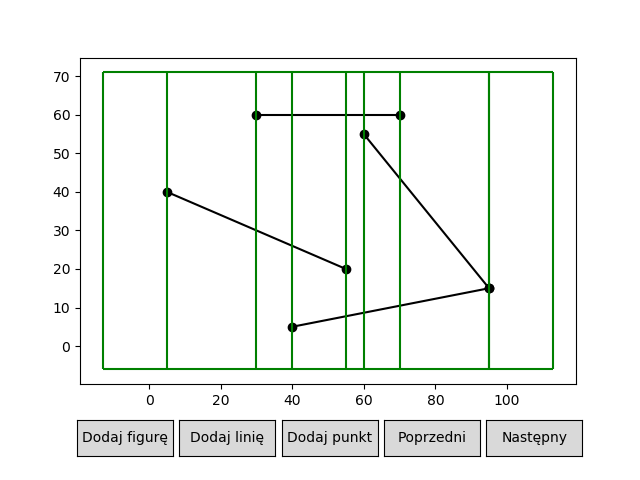

In [213]:
plot7=Plot(scenes=sScenes)
plot7.draw() 

In [194]:
import random


trapezoids, d, trapScenes = trapezoidal_map(lines)

<IPython.core.display.Javascript object>


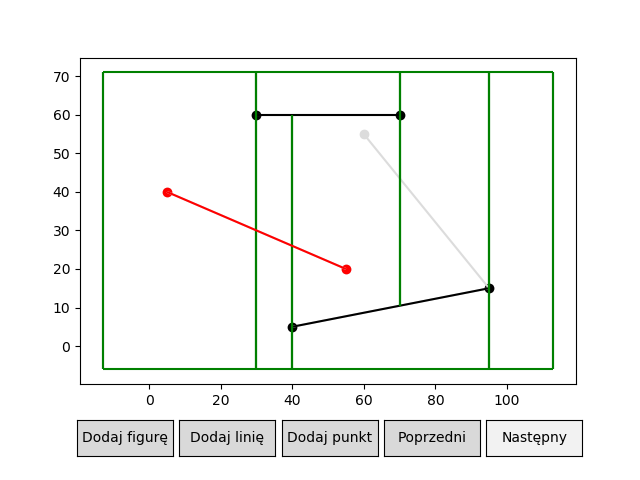

In [195]:
plot5=Plot(scenes=trapScenes)
plot5.draw() 

In [196]:
scenes = [trapScenes[-1]]
a = pointLocate(Point(45.0, 15.0, 'P'), d, scenes)

<IPython.core.display.Javascript object>


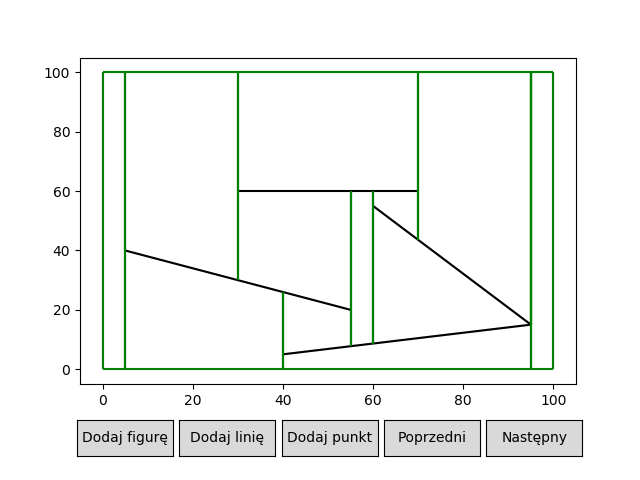

In [136]:
plo4=Plot(scenes = scenes)
plo4.draw() 